In [1]:
%load_ext autoreload
%autoreload 2

In [39]:
import random

from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import trange
import numpy as np  

from tensor import Tensor
from sgd import SGD

In [2]:
train_data = FashionMNIST('./fashion_data', train=True, download=True)
test_data = FashionMNIST('./fashion_data', train=False, download=True)

train_x = train_data.data.numpy()
train_y = train_data.targets.numpy()

test_x = test_data.data.numpy()
test_y = test_data.targets.numpy()

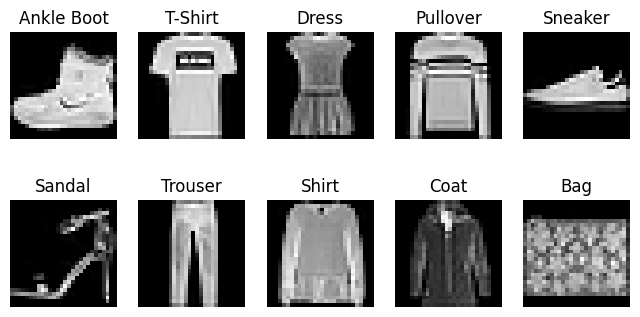

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

seen_labels = [] 

cur_index = 1

figure = plt.figure(figsize=(8, 4))

for idx in range(len(train_data)): 
    if len(seen_labels) == 10: 
        break 
    img, label = train_data[idx]
    if label in seen_labels: 
        continue 
    seen_labels.append(label)
    figure.add_subplot(2, 5, cur_index)
    cur_index = cur_index + 1
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img, cmap="gray")

plt.show()

In [5]:
print(train_data[0][0])

<PIL.Image.Image image mode=L size=28x28 at 0x12EBFB070>


In [4]:
def init_layer(m, h): 
    ret = np.random.uniform(-1., 1., size=(m, h))/np.sqrt(m * h)
    return ret.astype(np.float32)

class FashionModel: 
    def __init__(self): 
        self.w1 = Tensor(init_layer(28 * 28, 128))
        self.w2 = Tensor(init_layer(128, 128))
        self.w3 = Tensor(init_layer(128, 64))
        self.w4 = Tensor(init_layer(64, 10))

    def forward(self, x):
        return x.dot(self.w1).relu().dot(self.w2).relu().dot(self.w3).relu().dot(self.w4).logsoftmax()

    def params(self):
        return [self.w1, self.w2, self.w3, self.w4]


loss 27.64 accuracy 0.91: 100%|████████████| 5000/5000 [00:40<00:00, 124.42it/s]


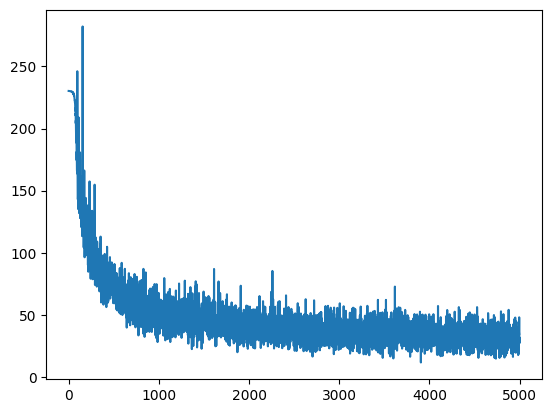

In [5]:
model = FashionModel()
optim = SGD(model.params(), 0.0001)

BATCH_SIZE = 100

epochs = 5000

losses, accuracies = [], []
for i in (t := trange(epochs)): 
    samp = np.random.randint(0, train_x.shape[0], size=(BATCH_SIZE))

    x = Tensor(train_x[samp].reshape((-1, 28*28)))
    Y = train_y[samp]
    y = np.zeros((len(samp), 10), np.float32)
    y[range(y.shape[0]),Y] = -1.0
    y = Tensor(y)


    outs = model.forward(x)


    loss = outs.mul(y).sum()
    loss.backward()
    optim.step()

    cat = np.argmax(outs.data, axis=1)
    
    accuracy = (cat == Y).mean()

    loss = loss.data
    losses.append(loss)
    accuracies.append(accuracy)
    t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))

plt.plot([x for x in range(epochs)], losses)




In [37]:
test_x = test_x.reshape(-1, 28*28)
t_test_x = Tensor(test_x.astype('float32'))
test_pred = model.forward(t_test_x)
t_test_y = Tensor(test_y)
    
cat = np.argmax(test_pred.data, axis=1)


test_acc = (cat == t_test_y.data).sum() / t_test_y.data.shape[0]
    
print(f"test acc is: {test_acc * 100}")

test acc is: 87.02


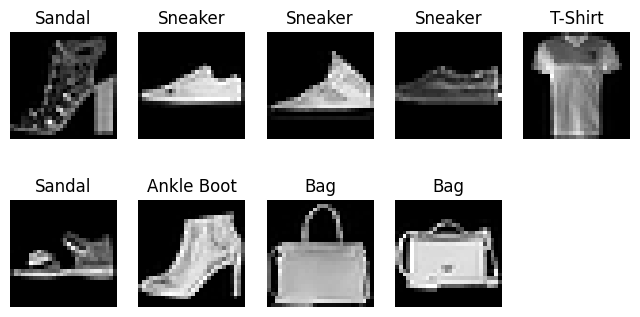

In [65]:
rnd_idx = random.sample(range(test_x.shape[0]), 9)

figure = plt.figure(figsize=(8, 4))

cur_index = 1

for idx in rnd_idx: 
    img = test_x[idx].reshape(28, 28)
    
    pred = model.forward(Tensor(test_x[idx].reshape(1, -1).astype('float32')))
    
    
    cat = np.argmax(pred.data, axis=1)

    figure.add_subplot(2, 5, cur_index)
    cur_index = cur_index + 1
    plt.title(labels_map[cat[0]])
    plt.axis("off")
    plt.imshow(img, cmap="gray")

plt.show()